In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import glob 
import shutil

In [6]:
inp_base_dir = '/Users/rakeshmohansharma/Downloads/Super_resData/input'
dirnames = ['LR', 'HR']
out_base_dir = './'

In [7]:
for dirname in dirnames:
  img_path = os.path.join(inp_base_dir, dirname)
  images = glob.glob(img_path + '/*.png')
  print("{}: {} Images".format(dirname, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(out_base_dir, 'train', dirname)):
      os.makedirs(os.path.join(out_base_dir, 'train', dirname))
    shutil.copy(t, os.path.join(out_base_dir, 'train', dirname))

  for v in val:
    if not os.path.exists(os.path.join(out_base_dir, 'val', dirname)):
      os.makedirs(os.path.join(out_base_dir, 'val', dirname))
    shutil.copy(v, os.path.join(out_base_dir, 'val', dirname))

LR: 100 Images
HR: 100 Images


In [8]:
train_dir = os.path.join(out_base_dir,'train')
val_dir  = os.path.join(out_base_dir, 'val')

In [15]:
def process_and_scale_train(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(train_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [16]:
def process_and_scale_val(filepath):
    img_input = tf.io.read_file(filepath)
    img_input = tf.image.decode_jpeg(img_input)
    img_input = tf.image.resize(img_input,[IMG_SHAPE,IMG_SHAPE])
    
    img_output = tf.io.read_file(val_dir + tf.strings.join(["/HR/", tf.strings.split(filepath, os.sep)[-1]]))
    img_output = tf.image.decode_jpeg(img_output)
    img_output = tf.image.resize(img_output,[IMG_SHAPE,IMG_SHAPE])
    
    return img_input/255., img_output/255.

In [12]:
import tensorflow as tf

In [17]:
train_ds_lr_files = tf.data.Dataset.list_files(train_dir + "/LR/*", shuffle = False)
val_ds_lr_files = tf.data.Dataset.list_files(val_dir + "/LR/*", shuffle = False)

In [21]:
IMG_SHAPE = 256
LATENT_DIM = 64
NUM_CHANNELS = 3

In [22]:
train_dataset_lr = train_ds_lr_files.shuffle(len(train_ds_lr_files)).map(process_and_scale_train).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset_lr = val_ds_lr_files.map(process_and_scale_val).batch(8).prefetch(tf.data.AUTOTUNE)

2022-07-13 11:53:09.063277: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


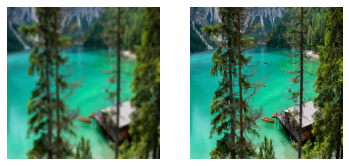

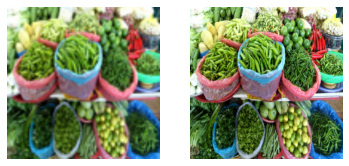

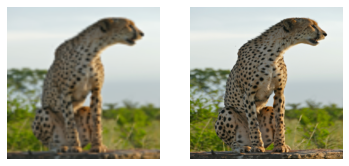

In [23]:
for train_lr, train_hr in train_dataset_lr.take(3):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(train_lr[0].numpy())
    ax[0].axis("off")
    ax[1].imshow(train_hr[0].numpy())
    ax[1].axis("off")

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Lambda, Reshape, Flatten

In [25]:
input_img = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)) #(accepts only 256, 256, 3)

In [27]:
l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l7)

l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l11)

l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

autoencoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

autoencoder.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01), #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')])

In [28]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [29]:
autoencoder.fit(train_dataset_lr,
                          validation_data = val_dataset_lr,
                          epochs = 200)

Epoch 1/200


2022-07-13 13:10:22.858840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.3214 - rmse: 0.4083

2022-07-13 13:10:36.887680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 16s 1s/step - loss: 0.3214 - rmse: 0.4083 - val_loss: 0.2878 - val_rmse: 0.3817
Epoch 2/200
10/10 [==============================] - 12s 1s/step - loss: 0.2805 - rmse: 0.3720 - val_loss: 0.2683 - val_rmse: 0.3659
Epoch 3/200
10/10 [==============================] - 12s 1s/step - loss: 0.2683 - rmse: 0.3634 - val_loss: 0.2595 - val_rmse: 0.3606
Epoch 4/200
10/10 [==============================] - 11s 1s/step - loss: 0.2619 - rmse: 0.3597 - val_loss: 0.2553 - val_rmse: 0.3579
Epoch 5/200
10/10 [==============================] - 11s 1s/step - loss: 0.2599 - rmse: 0.3579 - val_loss: 0.2516 - val_rmse: 0.3556
Epoch 6/200
10/10 [==============================] - 11s 1s/step - loss: 0.2545 - rmse: 0.3555 - val_loss: 0.2486 - val_rmse: 0.3536
Epoch 7/200
10/10 [==============================] - 11s 1s/step - loss: 0.2522 - rmse: 0.3537 - val_loss: 0.2476 - val_rmse: 0.3520
Epoch 8/200
10/10 [==============================] - 11s 1s/step - loss: 0.2492 -

10/10 [==============================] - 12s 1s/step - loss: 0.0810 - rmse: 0.1150 - val_loss: 0.0740 - val_rmse: 0.1073
Epoch 63/200
10/10 [==============================] - 12s 1s/step - loss: 0.0778 - rmse: 0.1115 - val_loss: 0.0726 - val_rmse: 0.1057
Epoch 64/200
10/10 [==============================] - 11s 1s/step - loss: 0.0767 - rmse: 0.1104 - val_loss: 0.0846 - val_rmse: 0.1190
Epoch 65/200
10/10 [==============================] - 12s 1s/step - loss: 0.0781 - rmse: 0.1115 - val_loss: 0.0751 - val_rmse: 0.1077
Epoch 66/200
10/10 [==============================] - 11s 1s/step - loss: 0.0778 - rmse: 0.1109 - val_loss: 0.0713 - val_rmse: 0.1037
Epoch 67/200
10/10 [==============================] - 12s 1s/step - loss: 0.0756 - rmse: 0.1083 - val_loss: 0.0819 - val_rmse: 0.1160
Epoch 68/200
10/10 [==============================] - 12s 1s/step - loss: 0.0763 - rmse: 0.1091 - val_loss: 0.0736 - val_rmse: 0.1061
Epoch 69/200
10/10 [==============================] - 13s 1s/step - loss: 0

10/10 [==============================] - 16s 2s/step - loss: 0.0619 - rmse: 0.0899 - val_loss: 0.0624 - val_rmse: 0.0900
Epoch 124/200
10/10 [==============================] - 16s 2s/step - loss: 0.0615 - rmse: 0.0893 - val_loss: 0.0600 - val_rmse: 0.0875
Epoch 125/200
10/10 [==============================] - 16s 2s/step - loss: 0.0615 - rmse: 0.0889 - val_loss: 0.0640 - val_rmse: 0.0917
Epoch 126/200
10/10 [==============================] - 15s 2s/step - loss: 0.0623 - rmse: 0.0899 - val_loss: 0.0607 - val_rmse: 0.0881
Epoch 127/200
10/10 [==============================] - 16s 2s/step - loss: 0.0614 - rmse: 0.0890 - val_loss: 0.0607 - val_rmse: 0.0881
Epoch 128/200
10/10 [==============================] - 15s 2s/step - loss: 0.0611 - rmse: 0.0887 - val_loss: 0.0593 - val_rmse: 0.0867
Epoch 129/200
10/10 [==============================] - 15s 2s/step - loss: 0.0605 - rmse: 0.0876 - val_loss: 0.0641 - val_rmse: 0.0914
Epoch 130/200
10/10 [==============================] - 15s 2s/step - 

Epoch 184/200
10/10 [==============================] - 16s 2s/step - loss: 0.0552 - rmse: 0.0813 - val_loss: 0.0533 - val_rmse: 0.0800
Epoch 185/200
10/10 [==============================] - 16s 2s/step - loss: 0.0549 - rmse: 0.0812 - val_loss: 0.0524 - val_rmse: 0.0794
Epoch 186/200
10/10 [==============================] - 15s 2s/step - loss: 0.0544 - rmse: 0.0807 - val_loss: 0.0571 - val_rmse: 0.0828
Epoch 187/200
10/10 [==============================] - 15s 2s/step - loss: 0.0553 - rmse: 0.0812 - val_loss: 0.0549 - val_rmse: 0.0810
Epoch 188/200
10/10 [==============================] - 15s 2s/step - loss: 0.0542 - rmse: 0.0804 - val_loss: 0.0556 - val_rmse: 0.0815
Epoch 189/200
10/10 [==============================] - 15s 2s/step - loss: 0.0548 - rmse: 0.0806 - val_loss: 0.0568 - val_rmse: 0.0825
Epoch 190/200
10/10 [==============================] - 15s 2s/step - loss: 0.0549 - rmse: 0.0810 - val_loss: 0.0533 - val_rmse: 0.0798
Epoch 191/200
10/10 [==============================] - 

<AxesSubplot:>

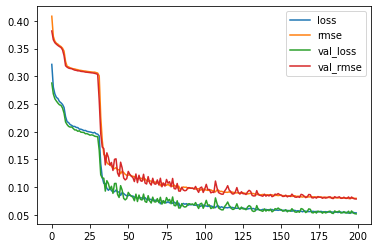

In [31]:
import pandas as pd
losses = pd.DataFrame(autoencoder.history.history)
losses.plot()

In [44]:
pred = autoencoder.predict(val_dataset_lr.take(1))

1/1 [==============================] - 0s 85ms/step


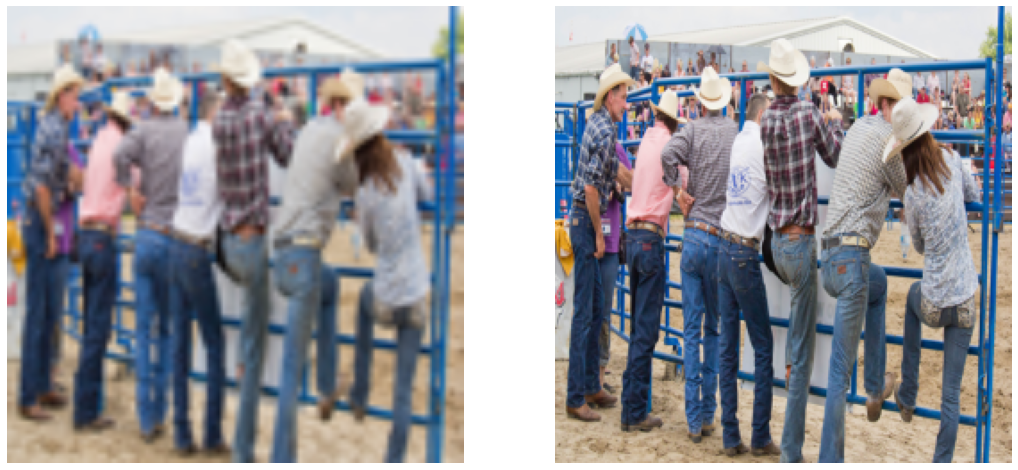

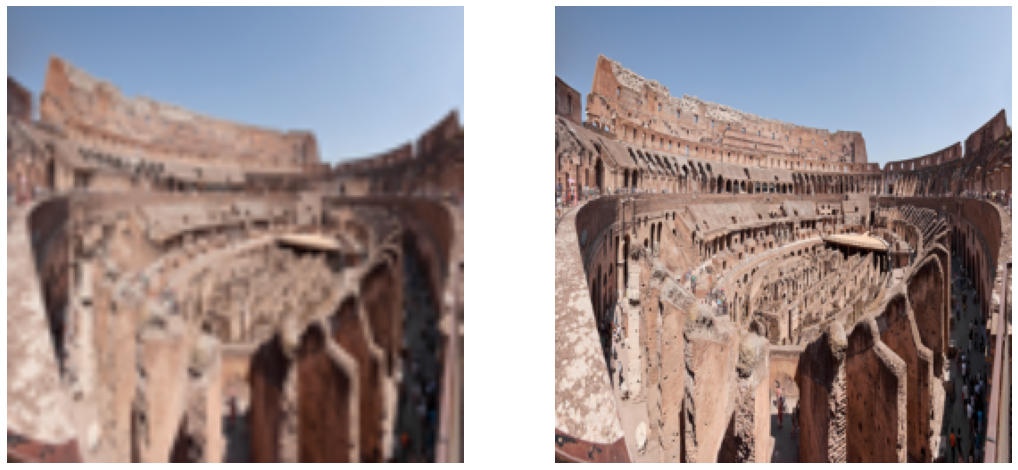

In [56]:
for img_input, img_output in val_dataset_lr.take(2):
    fig, ax = plt.subplots(1,2, figsize = (18,18))
    ax[0].imshow(img_input.numpy()[3])
    ax[0].axis("off")
    ax[1].imshow(img_output.numpy()[3])
    ax[1].axis("off")